# Binary Classification with a Bank Churn Dataset 2-1
## 1. ライブラリ

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

## 2. データの整理(Binary Classification with a Bank Churn Dataset 1の内容)
### 2.1. データ取入れ

In [2]:
# Binary Classification with a Bank Churn Dataset のデータセット
dir_path = '/kaggle/input/playground-series-s4e1/'
test = pd.read_csv(dir_path + 'test.csv')       # テストデータ
train = pd.read_csv(dir_path + 'train.csv')     # 訓練データ
samp_sub = pd.read_csv(dir_path + 'sample_submission.csv')

# Bank Customer Churn Prediction のデータセット
original = pd.read_csv('/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv')
original = original.rename({'RowNumber':'id'}, axis = 1)    # 根源データ

### 2.2. originalの確認

In [3]:
print('originalのデータ数   :', len(original))
print('CustomerIdのデータ数 :', len(original.CustomerId.unique()), end='\n\n')
print(original.tail())
print('\nindex 9998と9999, 10000と10001のデータが同じなので、整理する。')
original = original.drop(index=[9999, 10001])

originalのデータ数   : 10002
CustomerIdのデータ数 : 10000

          id  CustomerId    Surname  CreditScore Geography  Gender   Age  \
9997    9998    15584532        Liu          709    France  Female  36.0   
9998    9999    15682355  Sabbatini          772   Germany    Male  42.0   
9999    9999    15682355  Sabbatini          772   Germany    Male  42.0   
10000  10000    15628319     Walker          792    France  Female  28.0   
10001  10000    15628319     Walker          792    France  Female  28.0   

       Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
9997        7       0.00              1        0.0             1.0   
9998        3   75075.31              2        1.0             0.0   
9999        3   75075.31              2        1.0             0.0   
10000       4  130142.79              1        1.0             0.0   
10001       4  130142.79              1        1.0             0.0   

       EstimatedSalary  Exited  
9997          42085.58       1  
9998   

In [4]:
for col in original.columns:
    print(col.ljust(20), ': Nan =', original[col].isnull().sum())
print("\n Geography, Age, HasCrCard, IsActiveMemberに欠損値がある\n")
print('-'*80)
print("Geographyに欠損があるデータ:")
print(original[original.Geography.isnull()])
print('-'*80)
print("Ageに欠損があるデータ")
print(original[original.Age.isnull()])
print('-'*80)
print("HasCrCardに欠損があるデータ")
print(original[original.HasCrCard.isnull()])
print('-'*80)
print("IsActiveMemberに欠損があるデータ")
print(original[original.IsActiveMember.isnull()])
print('-'*80)
print("\n\n欠損のあるデータが4つしかないので、全部削除する")
original = original.drop(index=[4, 6, 8, 9])

id                   : Nan = 0
CustomerId           : Nan = 0
Surname              : Nan = 0
CreditScore          : Nan = 0
Geography            : Nan = 1
Gender               : Nan = 0
Age                  : Nan = 1
Tenure               : Nan = 0
Balance              : Nan = 0
NumOfProducts        : Nan = 0
HasCrCard            : Nan = 1
IsActiveMember       : Nan = 1
EstimatedSalary      : Nan = 0
Exited               : Nan = 0

 Geography, Age, HasCrCard, IsActiveMemberに欠損値がある

--------------------------------------------------------------------------------
Geographyに欠損があるデータ:
   id  CustomerId   Surname  CreditScore Geography Gender   Age  Tenure  \
6   7    15592531  Bartlett          822       NaN   Male  50.0       7   

   Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited  
6      0.0              2        1.0             1.0          10062.8       0  
--------------------------------------------------------------------------------
Ageに欠損があるデータ
   id  C

In [5]:
for col in ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']:
    print(col.ljust(20), ':', original[col].min(), '~', original[col].max())
print("\noriginalのデータ分布がtrain, testと一致する。")

CreditScore          : 350 ~ 850
Age                  : 18.0 ~ 92.0
Tenure               : 0 ~ 10
Balance              : 0.0 ~ 250898.09
NumOfProducts        : 1 ~ 4
EstimatedSalary      : 11.58 ~ 199992.48

originalのデータ分布がtrain, testと一致する。


In [6]:
# originalとtrainの結合
or_tr = pd.concat([train, original])    # 結合データ

### 2.3. 型変換

In [7]:
# 国データを整数データに変換するカテゴリ
Geography_cat = {'France'  : 0,
                 'Spain'   : 1,
                 'Germany' : 2}
# 性別データを整数データに変換するカテゴリ
Gender_cat = {'Female' : 0,
              'Male'   : 1}

# 全データの型変換
for data in [train, test, original, or_tr]:
    data.Geography = data.Geography.map(Geography_cat)
    data.Gender = data.Gender.map(Gender_cat)

### 2.4. 作成した特徴量

In [8]:
# CustomerIdの使用回数
# trainとtest
CI_used_t_cat = {}
for ci in set(train.CustomerId.unique()).union(set(test.CustomerId.unique())):
    # CustomerIdとその(trainとtest中の)使用回数を対応させるカテゴリ
    CI_used_t_cat[ci] = len(train[train.CustomerId==ci]) + len(test[test.CustomerId==ci])
for data in [train, test]:
    data['CI_used_t'] = data.CustomerId.map(CI_used_t_cat)

# or_trとtest
CI_used_ot_cat = {}
for ci in set(or_tr.CustomerId.unique()).union(set(test.CustomerId.unique())):
    # CustomerIdとその(or_trとtest中の)使用回数を対応させるカテゴリ
    CI_used_ot_cat[ci] = len(or_tr[or_tr.CustomerId==ci]) + len(test[test.CustomerId==ci])
for data in [or_tr, test]:
    data['CI_used_ot'] = data.CustomerId.map(CI_used_ot_cat)

    
# 各CustomerIdの口座解除率
# trainとtest
CI_rate_t_cat = {}
rate_t = train.Exited.sum()/len(train)
for ci in train.CustomerId.unique():
    # CustomerIdとその(train中の)口座解除確率を対応させる
    CI_rate_t_cat[ci] = (len(train[(train.CustomerId==ci)&(train.Exited==1)])+rate_t)/(len(train[train.CustomerId==ci])+1)
for ci in set(test.CustomerId.unique())-set(train.CustomerId.unique()):
    # trainにないCustomerIdをtrain全体の口座解除確率に対応させる
    CI_rate_t_cat[ci] = rate_t
for data in [train, test]:
    data['CI_rate_t'] = data.CustomerId.map(CI_rate_t_cat)
    
# or_trとtest
CI_rate_ot_cat = {}
rate_ot = or_tr.Exited.sum()/len(or_tr)
for ci in or_tr.CustomerId.unique():
    # CustomerIdとその(or_tr中の)口座解除確率を対応させる
    CI_rate_ot_cat[ci] = (len(or_tr[(or_tr.CustomerId==ci)&(or_tr.Exited==1)])+rate_ot)/(len(or_tr[or_tr.CustomerId==ci])+1)
for ci in set(test.CustomerId.unique())-set(or_tr.CustomerId.unique()):
    # or_trにないCustomerIdをor_tr全体の口座解除確率に対応させる
    CI_rate_ot_cat[ci] = rate_ot
for data in [or_tr, test]:
    data['CI_rate_ot'] = data.CustomerId.map(CI_rate_ot_cat)

## 3. ニューラルネットワークモデル
### 3.1. スケーリング

In [9]:
for data in [train, test, original, or_tr]:
    data.CreditScore = (data.CreditScore-data.CreditScore.min())/(data.CreditScore.max()-data.CreditScore.min())
    data.Geography = data.Geography/2
    data.Age = data.Age/100
    data.Tenure = data.Tenure/10
    data.Balance = (data.Balance-data.Balance.min())/(data.Balance.max()-data.Balance.min())
    data.NumOfProducts = data.NumOfProducts/4
    data.EstimatedSalary = (data.EstimatedSalary-data.EstimatedSalary.min())/(data.EstimatedSalary.max()-data.EstimatedSalary.min())
    if 'CI_used_ot' in data.columns:
        data.CI_used_ot = data.CI_used_ot/200
    if 'CI_used_t' in data.columns:
        data.CI_used_t = data.CI_used_t/200

### 3.2. 隠れ層

In [10]:
features_for_mlp = ['CreditScore', 'Geography', 'Age', 'Tenure', 'Balance',
                    'NumOfProducts', 'IsActiveMember', 'EstimatedSalary',
                    'CI_used_t', 'CI_rate_t']
tra, val = train_test_split(train, test_size = 0.3)
layers = [(100), (50, 100), (100, 100), (50, 100, 100), (100, 100, 50), (50, 100, 50)]
for l in layers:
    mlp = MLPClassifier(hidden_layer_sizes=l, solver='sgd', learning_rate='adaptive', learning_rate_init=0.3, random_state=0)
    mlp.fit(tra[features_for_mlp], tra.Exited)
    print('l=', l, '\n score=', mlp.score(val[features_for_mlp], val.Exited))

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


l= 100 
 score= 0.8800670558057805


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


l= (50, 100) 
 score= 0.8758457716467047


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


l= (100, 100) 
 score= 0.8736644382056513


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


l= (50, 100, 100) 
 score= 0.8727757468037406


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


l= (100, 100, 50) 
 score= 0.8721698208478924
l= (50, 100, 50) 
 score= 0.8748358950536245


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### 3.3. 活性化関数

In [11]:
features_for_mlp = ['CreditScore', 'Geography', 'Age', 'Tenure', 'Balance',
                    'NumOfProducts', 'IsActiveMember', 'EstimatedSalary',
                    'CI_used_t', 'CI_rate_t']
tra, val = train_test_split(train, test_size = 0.3)
mlp = MLPClassifier((50, 100, 100), activation='identity', solver='sgd', learning_rate='adaptive', learning_rate_init=0.3, random_state=0)
mlp.fit(tra[features_for_mlp], tra.Exited)
print('identity:', mlp.score(val[features_for_mlp], val.Exited))
mlp = MLPClassifier((50, 100, 100), activation='logistic', solver='sgd', learning_rate='adaptive', learning_rate_init=0.3, random_state=0)
mlp.fit(tra[features_for_mlp], tra.Exited)
print('logistic:', mlp.score(val[features_for_mlp], val.Exited))
mlp = MLPClassifier((50, 100, 100), activation='tanh', solver='sgd', learning_rate='adaptive', learning_rate_init=0.3, random_state=0)
mlp.fit(tra[features_for_mlp], tra.Exited)
print('tanh    :', mlp.score(val[features_for_mlp], val.Exited))
mlp = MLPClassifier((50, 100, 100), activation='relu', solver='sgd', learning_rate='adaptive', learning_rate_init=0.3, random_state=0)
mlp.fit(tra[features_for_mlp], tra.Exited)
print('relu    :', mlp.score(val[features_for_mlp], val.Exited))

identity: 0.8464785603199289


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


logistic: 0.8789561915533922


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


tanh    : 0.8736442406737897
relu    : 0.8718870554018299


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### 3.4. 最適化手法と最大反復学習回数
#### 3.4.1. 準ニュートン法

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS R

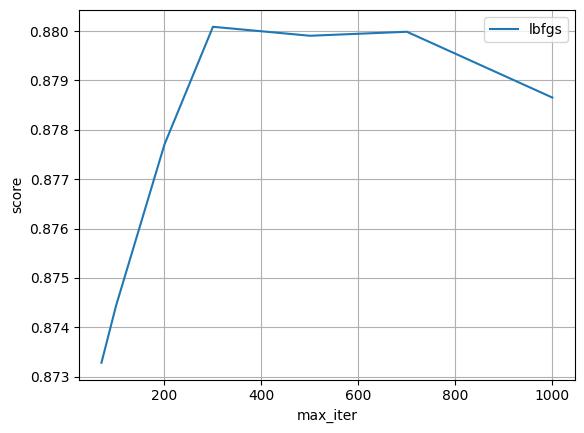

In [12]:
features_for_mlp = ['CreditScore', 'Geography', 'Age', 'Tenure', 'Balance',
                    'NumOfProducts', 'IsActiveMember', 'EstimatedSalary',
                    'CI_used_t', 'CI_rate_t']
tra, val = train_test_split(train, test_size = 0.3)
max_iter = [70, 100, 200, 300, 500, 700, 1000]
scores = []
for i in max_iter:
    mlp = MLPClassifier((50, 100, 100), solver='lbfgs', max_iter=i, random_state=0)
    mlp.fit(tra[features_for_mlp], tra.Exited)
    scores.append(mlp.score(val[features_for_mlp], val.Exited))
fig = plt.figure()
plt.plot(max_iter, scores, label='lbfgs')
plt.xlabel('max_iter')
plt.ylabel('score')
plt.grid()
plt.legend()
plt.show()

### 3.4.2. 勾配降下法

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (30) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (70) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.

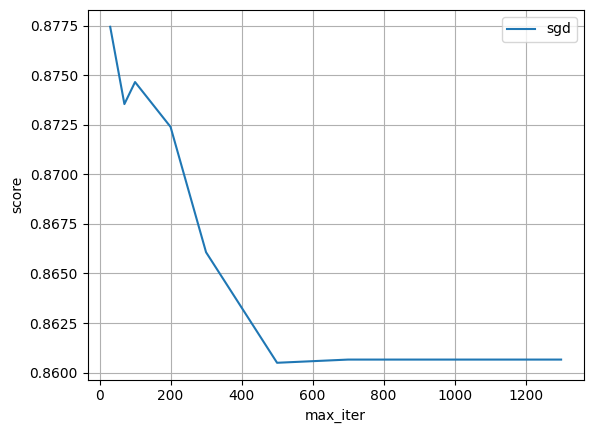

In [13]:
features_for_mlp = ['CreditScore', 'Geography', 'Age', 'Tenure', 'Balance',
                    'NumOfProducts', 'IsActiveMember', 'EstimatedSalary',
                    'CI_used_t', 'CI_rate_t']
tra, val = train_test_split(train, test_size = 0.3)
max_iter = [30, 70, 100, 200, 300, 500, 700, 1000, 1300]
scores = []
for i in max_iter:
    mlp = MLPClassifier((50, 100, 100), solver='sgd', max_iter=i, learning_rate='adaptive', learning_rate_init=0.3, random_state=0)
    mlp.fit(tra[features_for_mlp], tra.Exited)
    scores.append(mlp.score(val[features_for_mlp], val.Exited))
fig = plt.figure()
plt.plot(max_iter, scores, label='sgd')
plt.xlabel('max_iter')
plt.ylabel('score')
plt.grid()
plt.legend()
plt.show()

### 3.4.3. 適応的モーメント推定

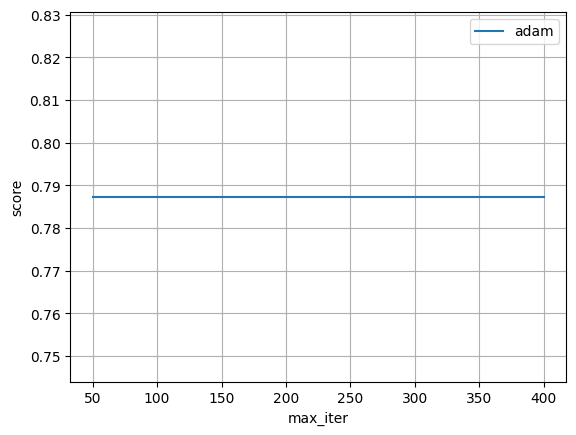

In [14]:
features_for_mlp = ['CreditScore', 'Geography', 'Age', 'Tenure', 'Balance',
                    'NumOfProducts', 'IsActiveMember', 'EstimatedSalary',
                    'CI_used_t', 'CI_rate_t']
tra, val = train_test_split(train, test_size = 0.3)
max_iter = [50, 100, 200, 300, 400]
scores = []
for i in max_iter:
    mlp = MLPClassifier((50, 100, 100), solver='adam', max_iter=i, learning_rate_init=0.3, random_state=0)
    mlp.fit(tra[features_for_mlp], tra.Exited)
    scores.append(mlp.score(val[features_for_mlp], val.Exited))
fig = plt.figure()
plt.plot(max_iter, scores, label='adam')
plt.xlabel('max_iter')
plt.ylabel('score')
plt.grid()
plt.legend()
plt.show()